<a href="https://colab.research.google.com/github/john-d-noble/Pball-Model/blob/main/v9_Target_IRR_Model_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧮 Comprehensive IRR Model Analysis

This notebook models four investment scenarios for a pickleball club, computes IRR and NPV, and visualizes the free cash flow profile.

## 🔧 Core Financial Model
This cell defines the full configuration, financial logic, and scenario execution.

In [1]:
pip install numpy-financial


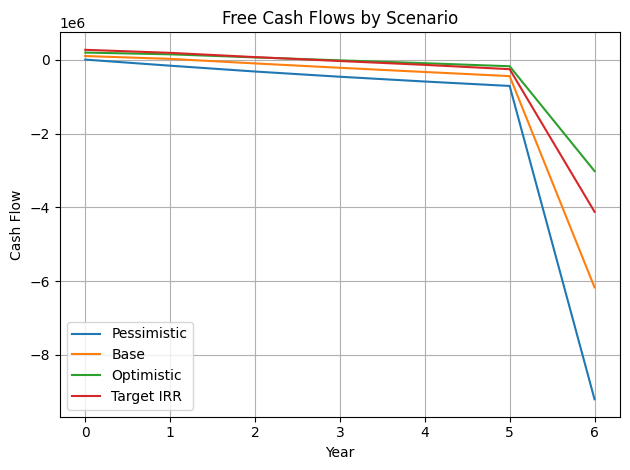

,Scenario,NPV,IRR
0,Pessimistic,-6156795.0,29.406
1,Base,-3693906.0,1.217
2,Optimistic,-1314802.0,0.487
3,Target IRR,-1843536.0,0.501


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy_financial import irr, npv

# ---- Scenario Inputs ----
pessimistic = {
    'monthly_membership_fee': 80,
    'court_utilization_year1': 0.25,
    'member_churn_rate': 0.28,
    'initial_investment': 1000000
}
base = {
    'monthly_membership_fee': 90,
    'court_utilization_year1': 0.30,
    'member_churn_rate': 0.22,
    'initial_investment': 900000
}
optimistic = {
    'monthly_membership_fee': 100,
    'court_utilization_year1': 0.35,
    'member_churn_rate': 0.18,
    'initial_investment': 850000
}
target_irr = {
    'monthly_membership_fee': 110,
    'court_utilization_year1': 0.38,
    'member_churn_rate': 0.22,
    'initial_investment': 900000
}

# ---- Base Configuration ----
base_config = {
    'working_capital_percent_revenue': 0.08,
    'contingency_reserve': 100000,
    'financing_ratio': 0.7,
    'interest_rate': 0.08,
    'loan_term_years': 10,
    'num_courts': 12,
    'court_hours_per_day': 14,
    'days_open_per_year': 360,
    'facility_square_feet': 24000,
    'capacity_members': 1200,
    'prime_time_rate': 25,
    'off_peak_rate': 15,
    'prime_time_percentage': 0.4,
    'ancillary_rev_per_member_monthly': 20,
    'rent_per_sqft_monthly': 1.25,
    'utilities_base': 3500,
    'utilities_per_sqft': 0.15,
    'insurance_monthly': 2800,
    'staff_management': 12000,
    'staff_front_desk': 8000,
    'staff_maintenance': 4000,
    'staff_instructors_base': 3000,
    'staff_instructors_variable': 3000,
    'marketing_base': 5000,
    'equipment_maintenance_monthly': 1500,
    'supplies_monthly': 800,
    'professional_services': 1200,
    'equipment_replacement_annual': 20000,
    'operating_cost_inflation': 0.05,
    'rent_escalation': 0.03,
    'franchise_fee': 65000,
    'royalty_rate': 0.08,
    'marketing_fee_rate': 0.02,
    'years': 7,
    'tax_rate': 0.25,
    'terminal_growth_rate': 0.02,
    'discount_rate': 0.12,
    'member_acquisition_rate': 0.15,
    'max_utilization': 0.75,
    'num_members_year1': 800
}

MACRS_7_YEAR = [0.1429, 0.2449, 0.1749, 0.1249, 0.0893, 0.0892, 0.0893]

# Function continues below...

def calculate_cash_flows(cfg):
    years = cfg['years']
    capex = cfg['initial_investment']
    total_investment = capex + cfg['contingency_reserve'] + cfg['franchise_fee']
    loan_amount = cfg['financing_ratio'] * total_investment
    equity = total_investment - loan_amount

    r = cfg['interest_rate']
    n = cfg['loan_term_years']
    pmt = loan_amount * r / (1 - (1 + r) ** -n)
    debt_schedule = []
    remaining = loan_amount

    for year in range(1, years + 1):
        interest = remaining * r
        principal = pmt - interest
        remaining -= principal
        if remaining < 0: remaining = 0
        debt_schedule.append({'interest': interest, 'principal': principal})

    court_capacity_hours = cfg['num_courts'] * cfg['court_hours_per_day'] * cfg['days_open_per_year']
    members = cfg['num_members_year1']
    utilization = cfg['court_utilization_year1']

    fcf = []
    revenues = []
    member_list = []

    for year in range(years):
        # Revenue
        court_hours_used = court_capacity_hours * min(utilization, cfg['max_utilization'])
        court_rev = court_hours_used * (
            cfg['prime_time_percentage'] * cfg['prime_time_rate'] +
            (1 - cfg['prime_time_percentage']) * cfg['off_peak_rate']
        )
        member_rev = members * cfg['monthly_membership_fee'] * 12
        ancillary_rev = members * cfg['ancillary_rev_per_member_monthly'] * 12
        total_rev = court_rev + member_rev + ancillary_rev
        revenues.append(total_rev)
        member_list.append(members)

        # Costs
        rent = cfg['facility_square_feet'] * cfg['rent_per_sqft_monthly'] * 12 * ((1 + cfg['rent_escalation']) ** year)
        utilities = cfg['utilities_base'] + cfg['utilities_per_sqft'] * cfg['facility_square_feet']
        insurance = cfg['insurance_monthly'] * 12
        staff = (cfg['staff_management'] + cfg['staff_front_desk'] +
                 cfg['staff_maintenance'] + cfg['staff_instructors_base'] +
                 cfg['staff_instructors_variable']) * 12
        marketing = cfg['marketing_base'] * 12
        ops_costs = rent + utilities + insurance + staff + marketing +                     cfg['equipment_maintenance_monthly'] * 12 +                     cfg['supplies_monthly'] * 12 + cfg['professional_services'] * 12
        ops_costs *= ((1 + cfg['operating_cost_inflation']) ** year)

        franchise_fees = total_rev * (cfg['royalty_rate'] + cfg['marketing_fee_rate'])
        depreciation = capex * MACRS_7_YEAR[year] if year < len(MACRS_7_YEAR) else 0
        capex_renewal = cfg['equipment_replacement_annual']
        interest = debt_schedule[year]['interest'] if year < len(debt_schedule) else 0
        principal = debt_schedule[year]['principal'] if year < len(debt_schedule) else 0
        ebt = total_rev - ops_costs - franchise_fees - depreciation - interest
        tax = max(0, ebt * cfg['tax_rate'])
        net_income = ebt - tax

        working_cap = total_rev * cfg['working_capital_percent_revenue']
        fcf.append(net_income + depreciation - capex_renewal - working_cap - principal)

        # Update for next year
        members = members * (1 + cfg['member_acquisition_rate']) * (1 - cfg['member_churn_rate'])
        utilization = utilization * 1.05

    # Terminal Value
    tv = fcf[-1] * (1 + cfg['terminal_growth_rate']) / (cfg['discount_rate'] - cfg['terminal_growth_rate'])
    fcf[-1] += tv

    return fcf, npv(cfg['discount_rate'], fcf), irr(fcf)

# Run scenarios
scenarios = {'Pessimistic': pessimistic, 'Base': base, 'Optimistic': optimistic, 'Target IRR': target_irr}
results = []

for name, overrides in scenarios.items():
    cfg = base_config.copy()
    cfg.update(overrides)
    fcf, scenario_npv, scenario_irr = calculate_cash_flows(cfg)
    results.append({'Scenario': name, 'NPV': round(scenario_npv, 0), 'IRR': round(scenario_irr, 3)})
    plt.plot(fcf, label=f"{name}")

plt.title("Free Cash Flows by Scenario")
plt.xlabel("Year")
plt.ylabel("Cash Flow")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Tabulate results
df_results = pd.DataFrame(results)
display(df_results)


## 📈 Results Overview
Displays the IRR and NPV by scenario after plotting Free Cash Flow by year.

In [ ]:
df_results